In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import glob
import scipy
import pdb
from tqdm import tqdm
import pickle
import sys
from matplotlib import pyplot as plt
import h5py
from pynwb import NWBHDF5IO

In [3]:
import sys

In [4]:
sys.path.append('/home/akumar/nse/neural_control')

In [5]:
from loaders import load_sabes_wf, load_sabes

In [10]:
#wf = load_sabes_wf('/home/akumar/nse/neural_control/data/indy_20160624_03.mat')
wf = load_sabes_wf('/mnt/sdb1/nc_data/sabes/indy_20160624_03.mat')

In [13]:
dat = load_sabes('/home/akumar/nse/neural_control/data/indy_20160624_03.mat')

In [14]:
dat['spike_rates'].shape

(1, 9998, 149)

In [25]:
wf[0].shape

(171, 48)

In [ ]:
# Feature construction
# (1) Trough to peak duration (global minimum to local maximum subsequently)
# (2) Repolarization time (time between late peak and inflection point of the curve)

In [28]:
.0002/(2.5 * 1e-6)

80.00000000000001

In [25]:
1/5000

0.0002

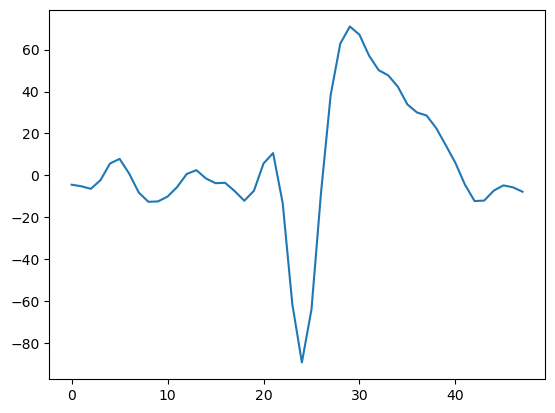

In [39]:
plt.plot(wf[10][3, :])

In [8]:
data_files = glob.glob('/mnt/sdb1/nc_data/sabes/*.mat')    

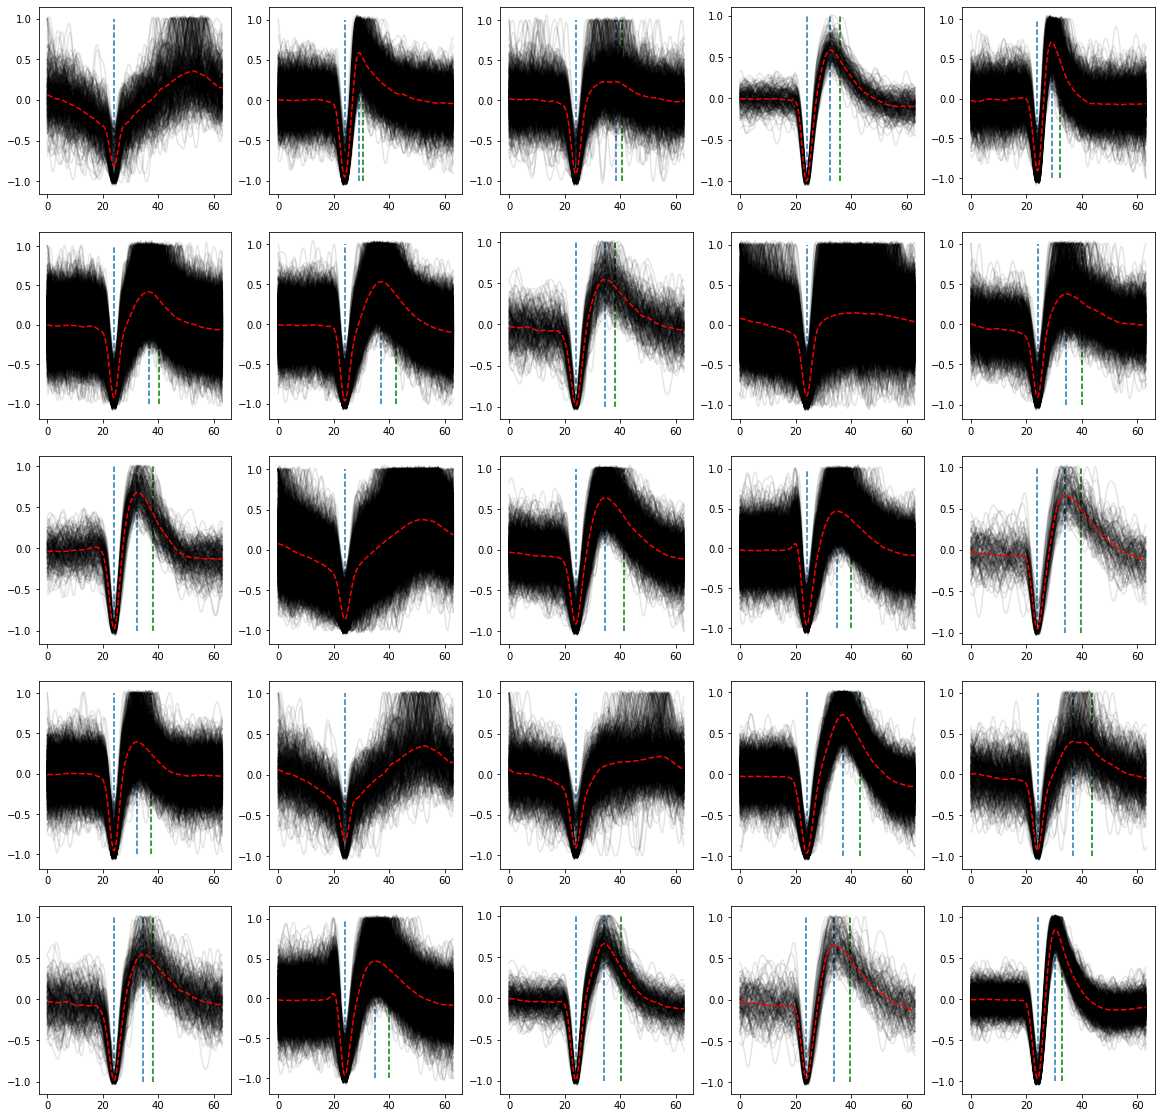

In [68]:
# In Kaufman, Shenoy, the waveforms are averaged prior to classifying waveform statistics. Let's co-plot all the spikes from a few neurons to assess how repeatable shape is, 
# and whether additional rejection criteria are required

# Note the discussion at the end of the paper: Results will generally be cleaner with single electrodes than multiarrays. However, the latter is now canonical, and the 
# current biology article uses tungsten microelectrodes

wf = load_sabes_wf(data_file)

fig, ax = plt.subplots(5, 5, figsize=(20, 20))

random = np.random.RandomState(12)
idxs = random.choice(np.arange(len(wf)), 25)

for i in range(25):
    a = ax[np.unravel_index(i, (5, 5))]
    cell = wf[idxs[i]]
    spikes = []
    for j, spike in enumerate(cell):
        # Upsample the spike
        t1 = np.arange(len(spike))
        t2 = np.linspace(0, t1[-1], t1.size * 50)
        # Normalize
        spike /= np.max(np.abs(spike))
        sinterp = scipy.interpolate.CubicSpline(t1, spike)
        spike_ = sinterp(t2)
        a.plot(t2, spike_, color='k', alpha=0.1)
        spikes.append(spike_)

    # We want to exclude neurons that do not have a peak following the trough        
    spike = np.mean(spikes, axis=0)

    # Global minima
    gmin = np.argmin(spike)

    # local maxima
    pks = scipy.signal.find_peaks(spike, height=0, prominence=0.2)[0]
    # After the minimum
    pks = pks[pks > gmin]

    # But before too long...
    pks = pks[t2[pks] - t2[gmin] < 25]

    # Plot vertical line where the global minimum is identified
    a.vlines(t2[gmin], -1, 1, linestyles='dashed')
    if len(pks) > 0:
        a.vlines(t2[pks[0]], -1, 1, linestyles='dashed')

        # Using the averaged traces, the post peak inflection point may be measurable
        # Use just the first derivative to reduce numerical noise
        ds = np.diff(spike)
        ds = np.abs(ds)/np.max(np.abs(ds))
        
        dpks = scipy.signal.find_peaks(np.abs(ds)/np.max(np.abs(ds)), height=0.05)[0]
        if len(dpks > 0):
            dpks = dpks[dpks > pks[0]]
        if len(dpks) > 0:
            a.vlines(t2[dpks[0]], -1, 1, color='green', linestyles='dashed')


    a.plot(t2, spike, color='r', linestyle='--')

In [61]:
scipy.signal.find_peaks(np.abs(d2)/np.max(np.abs(d2)), height=0.05)

(array([1141, 1311, 1795, 2072, 2288]),
 {'peak_heights': array([0.70265706, 1.        , 0.20602255, 0.1213939 , 0.05394155])})

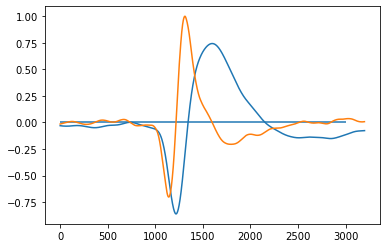

In [55]:
plt.plot(spike)
#d2 = np.diff(np.diff(spike))
d2 = np.diff(spike)
plt.plot(d2/np.max(np.abs(d2)))
plt.hlines(0, 0, 3000)
#plt.ylim([-0.1, 0.1])

In [11]:
# Extract the spike width and hyperpolarization
def extract_wf_features(spikes):

    spikes_pp = []
    for spike in spikes:
        t1 = np.arange(len(spike))
        t2 = np.linspace(0, t1[-1], t1.size * 50)
        # Normalize
        spike /= np.max(np.abs(spike))
        sinterp = scipy.interpolate.CubicSpline(t1, spike)
        spike_ = sinterp(t2)
        spikes_pp.append(spike_)

    # We want to exclude neurons that do not have a peak following the trough        
    spike = np.mean(spikes_pp, axis=0)

    # Global minima
    gmin = np.argmin(spike)

    # local maxima
    pks = scipy.signal.find_peaks(spike, height=0, prominence=0.2)[0]
    # After the minimum
    pks = pks[pks > gmin]

    # But before too long...
    pks = pks[t2[pks] - t2[gmin] < 25]

    # Normalize
    if len(pks) == 0:
        return np.nan, np.nan
    else:
        # Using the averaged traces, the post peak inflection point may be measurable
        # Use just the first derivative to reduce numerical noise
        ds = np.diff(spike)
        ds = np.abs(ds)/np.max(np.abs(ds))
        
        dpks = scipy.signal.find_peaks(np.abs(ds)/np.max(np.abs(ds)), height=0.05)[0]
        if len(dpks > 0):
            dpks = dpks[dpks > pks[0]]
            if len(dpks > 0):
                return pks[0] - gmin, dpks[0] - pks[0]
            else:
                return pks[0] - gmin, np.nan        
        else:
            return pks[0] - gmin, np.nan

In [12]:
spike_widths = []
phrt = []
for i, data_file in tqdm(enumerate(data_files)):
    wf = load_sabes_wf(data_file)
    for cell in wf:
        sw, phrt_ = extract_wf_features(cell)
        spike_widths.append(sw)
        phrt.append(phrt_)    

38it [1:43:40, 163.70s/it]


In [13]:
with open('cell_classification_calc.dat', 'wb') as f:
    f.write(pickle.dumps(spike_widths))
    f.write(pickle.dumps(phrt))

In [22]:
np.invert(np.isnan(spike_widths))

array([ True,  True,  True, ..., False,  True,  True])

In [24]:
spike_widths_filtered = np.array(spike_widths)[np.bitwise_and(np.invert(np.isnan(spike_widths)), np.invert(np.isnan(phrt)))]
phrt_filtered = np.array(phrt)[np.bitwise_and(np.invert(np.isnan(spike_widths)), np.invert(np.isnan(phrt)))]

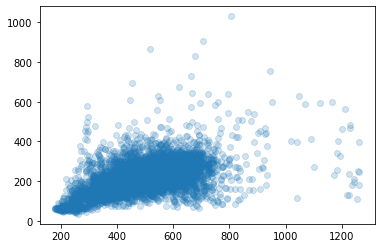

In [27]:
plt.scatter(spike_widths, phrt, alpha=0.2)

(array([ 50., 113., 121., 144., 119., 125., 205., 192., 169., 218., 247.,
        252., 216., 205., 190., 239., 289., 258., 256., 270., 196., 200.,
        207., 124.,  81.,  62.,  32.,  20.,  18.,  11.,   9.,   6.,   5.,
          5.,   9.,   2.,   1.,   0.,   1.,   2.,   1.,   1.,   2.,   1.,
          0.,   2.,   4.,   3.,   5.,   7.]),
 array([ 179.  ,  200.66,  222.32,  243.98,  265.64,  287.3 ,  308.96,
         330.62,  352.28,  373.94,  395.6 ,  417.26,  438.92,  460.58,
         482.24,  503.9 ,  525.56,  547.22,  568.88,  590.54,  612.2 ,
         633.86,  655.52,  677.18,  698.84,  720.5 ,  742.16,  763.82,
         785.48,  807.14,  828.8 ,  850.46,  872.12,  893.78,  915.44,
         937.1 ,  958.76,  980.42, 1002.08, 1023.74, 1045.4 , 1067.06,
        1088.72, 1110.38, 1132.04, 1153.7 , 1175.36, 1197.02, 1218.68,
        1240.34, 1262.  ]),
 <BarContainer object of 50 artists>)

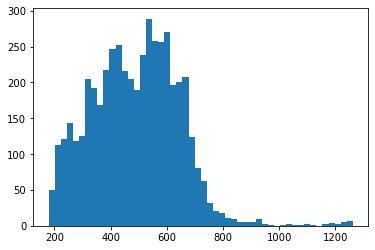

In [31]:
plt.hist(spike_widths, bins=50)

In [ ]:
# Evaluate some of these outliers. Are we filtering things out correctly?

In [26]:
np.argmax(spike_widths)

17

In [ ]:
# Separate analysis by monkey, and run it again with the raw broadband signal. Additional feature: average firing rate during different portions of the reach, or the
# entire recording. Plot spike width vs. firing rate

In [ ]:
# Can also try UMAP + clustering 

In [ ]:
# Things to try: Go with the raw broadband recordings instead, search for other features that one might be able to use to differentiate cell types
# Also: can we get the xyz position of electrodes and therefore some measure of the depth of the spikes?